In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%pylab inline
from sympy.integrals.quadrature import gauss_lobatto
from sympy.physics.wigner import wigner_3j
from sympy import KroneckerDelta
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import gmres
from scipy.interpolate import interp1d
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import eigsh
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


In [3]:
def scalpot_r(x,pos = 0.0):
    s2  = (1.2741)**2;
    Vp  = 0.07349864;
    lam = 10.0;
    Vs = Vp * exp(-abs(x-pos)/lam) / sqrt((x-pos)**2 + s2);
    return (Vs)


def scalpot0_r(x,pos = 0.0):
    s2  = (1.2741)**2;
    V1  = -1;
    lam = 10.0;
    Vs = V1 * exp(-abs(x-pos)/lam) / sqrt((x-pos)**2 + s2);
    return (Vs)


In [4]:
class GLQuadrature:
    
    def __init__(self,n=15):
        x, w = gauss_lobatto(n,15)
        self.x=array(x).astype(float)
        self.w=array(w).astype(float)
        self.n = n
        self.gldmat=self.Derivative()
        
    def Derivative(self):
        #calcualte (one elment [-1,1]) GaussLobatto derivative matrix
        dmat=array([array(zeros(self.n)) for i in range(self.n)])
        for i in range(self.n):
            for j in range(self.n):
                if i!=j:
                    pr=1./(self.x[j]-self.x[i])
                    dmat[i,i]-=pr
                    for k in range(self.n):
                        if (k!=i)and(k!=j):
                            pr*=(self.x[i]-self.x[k])/(self.x[j]-self.x[k])
                    dmat[i,j]+=pr
    
        return dmat
    
        
    def Info(self):
        print ("quadrature order=", self.n)
        
    def Rescale(self,a,b):
        x=(self.x+1.)*(b-a)/(2.)+a
        w=self.w*(b-a)/2.
        return (x,w)
  

In [5]:
class FEMDVR(GLQuadrature):
    
    def __init__(self,fe=[0.,1.,2.],n=5,nECS=-1,phiECS=pi/4):
        GLQuadrature.__init__(self, n=n)
        if(nECS!=-1):
            self.nECS=nECS
            self.phiECS=phiECS
            feECS=array(fe).astype(complex)
            rECS=fe[nECS].astype(complex)
            feECS[nECS:]=rECS + exp(1.j*phiECS)*(feECS[nECS:]-rECS)
            rECS=fe[-nECS-1].astype(complex)
            feECS[:-nECS-1]=rECS + exp(1.j*(phiECS))*(feECS[:-nECS-1]-rECS)
            fe=feECS
        
        self.fe=array(fe)
        self.xa,self.wa=self.ConstructFEMDVRgrid()
        self.xz,self.wz=self.xa[1:-1],self.wa[1:-1]
        self.d1matrix,self.d2matrix=self.Getdmat()
        
    def Info(self):
        GLQuadrature.Info(self)
        print ("        fem grid=", self.fe)
        
        
    def ConstructFEMDVRgrid(self):
        #construct FEM-DVR grid and wights: fe=FEM grid; n=DVR order 
        xa=array([])
        wa=array([])
        wafin=0.
        for i in range(1,len(self.fe)):
            x,w=GLQuadrature.Rescale(self,a=self.fe[i-1],b=self.fe[i])
            w[0]+=wafin
            if(i!=len(self.fe)-1):
                xa=append(xa,x[:-1])
                wa=append(wa,w[:-1])
            else:
                xa=append(xa,x)
                wa=append(wa,w)
            wafin=w[-1]

        return (xa,wa)
    
    
    def Getdmat(self):
        nbas=len(self.xz)
        dmat=array([array(zeros(nbas)) for i in range(nbas)]).astype(complex)
        dmat2=array([array(zeros(nbas)) for i in range(nbas)]).astype(complex)
        ntot=len(self.xa)
            
        xi=array(range(ntot))
        b=[]
        for i in range(len(self.fe)-1):
            b.append(xi[-self.n:])
            xi=xi[0:-self.n+1]

        b=array(list(reversed(b)))
        dmatx=array(self.gldmat).astype(complex)
    
        for l in range(len(b)):
            if l==0:
                bb=b[l,1:]
            elif l==len(b)-1:
                bb=b[l,:-1]
            else:
                bb=b[l]
            #print bb#
            for ii in bb:
                i=where( b[l]==ii )[0]
                for jj in bb:
                    j=where( b[l]==jj )[0]
                    de=dmatx[i,j]/(self.fe[l+1]-self.fe[l])*2.*sqrt(self.wa[ii]/self.wa[jj])
                    dmat[ii-1,jj-1]+=de[0]
                    #
                    de=0.
                    for m in range(self.n):
                        de+=dmatx[m,i]*dmatx[m,j]*2./(self.fe[l+1]-self.fe[l])*(self.w[m]/sqrt(self.wa[ii]*self.wa[jj]))
                    dmat2[ii-1,jj-1]-=de[0]
                    #

        for ii in range(self.n-2,len(dmat),self.n-1):
            dmat[ii,:]*=0.5
                
        return (dmat,dmat2) 

In [6]:
dx=5.    #FEM-element size, de broglie wavelength should not be  smaller than dx/4 
xmax=500 #FEM-grid size from -xmax to xmax 
fe=arange(-xmax,xmax+1,dx)
femgrid=FEMDVR(fe=fe,n=15,nECS=-1)

Ekin=-0.5*femgrid.d2matrix
V = array([scalpot0_r(xx,pos=0) for xx in femgrid.xz])   #Potential defind in scalpot0_r(x) function
H0=real(Ekin+diag(V))

H0s=csc_matrix(H0)   #Hamiltonian
e,v=eigsh(H0s,k=4,which='SA')
e0=e[0]  #ground state energy
Phi0=v[:,0]  #ground wave function 
print (real(sort(e)[:10]))

[-0.50001286 -0.17144591 -0.06709886 -0.02258791]


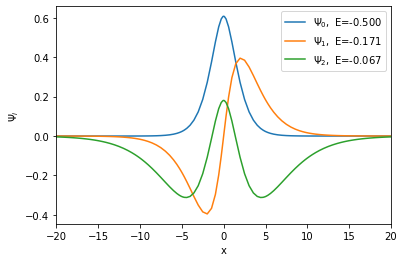

In [7]:
for i in [0,1,2]:
    plot(real(femgrid.xz),real(v[:,i]/sqrt(femgrid.wz)),label="$\Psi_{"+str(i)+"},$ E="+str(e[i])[:6])
xlim(-20,20)
xlabel("x")
ylabel("$\Psi_i$")
legend()

In [8]:
#monocromatic sin2-enevelope eletric filed 
def ElField(t,Iwcm2=1.e+12,w0=0.0569541043,T=41.341374575751,phase=0,t0=0):
    #*** 1 W/cm^2 = 1.5536613E-16 a.u., F0 = sqrt(2*Imax/(c e_0)), c = 137 a.u., e_0 = 1/(4 pi)
    Iau=Iwcm2*1.5536613E-16
    c=137.036
    E0=sqrt(2*Iau/(c/(4*pi)))
    f=E0*sin(pi*(t-t0)/T)**2*sin(w0*(t-t0)+phase)
    return f


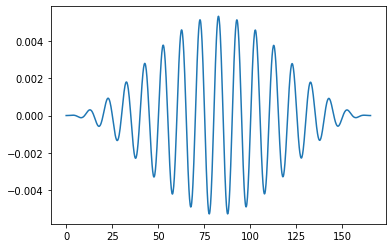

In [9]:
w0=0.0569541043*11  #
T=4*41.341374575751
t=linspace(0,T,1000)
f=array([ElField(tt,T=T,w0=w0) for tt in t])
plot(t,f)

In [10]:
import scipy.sparse.linalg as spla

def interplxyxnew(x,y,xnew):
    #interpolate x,y data
    f=interp1d(x, y, kind='linear')
    ynew = f(xnew)
    return(ynew)

def CNtdse(phi0,H0,V,dt,fieldE):
    # propagatge wave function using Crank–Nicolson propagator for TDSE
    H2=H0*0.5j*dt
    V2=V*0.5j*dt
    ID=identity(H0.shape[0])
    # (1+idt/2*H)x=(1-idt/2*H)u    
    H2s=csc_matrix(H2)
    IDs=csc_matrix(ID)
    V2s=csc_matrix(V2)
    
    t0=fieldE[0,0]
    t1=fieldE[-1,0]
    phi0final=phi0
    for t in arange(t0,t1,dt):
        f=interplxyxnew(fieldE[:,0],fieldE[:,1],t)
        Hs=f*V2s
        Hs+=H2s
        rhs=phi0final-Hs.dot(phi0final)
        LHS=IDs+Hs
        #phi0final = spsolve(LHS, rhs)
        phi0final, exitCode = spla.gmres(LHS, rhs,x0=phi0final,tol=1e-012) #bicgstab, gmres more accruate but slower
        if(exitCode!=0):
            print("not converged: t=",t)
            return phi0final
            
    return phi0final


In [11]:
dt=0.1  #time step (should be decreased with increasing pulse energy)
fieldE=array([t,f]).transpose()
dipOpLen=csc_matrix(diag(femgrid.xz)) 
phifinal=CNtdse(Phi0,H0,dipOpLen,dt,fieldE)

In [12]:
dt=0.2
fieldE=array([t,f]).transpose()
dipOpLen=csc_matrix(diag(femgrid.xz))
phifinal_2=CNtdse(Phi0,H0,dipOpLen,dt,fieldE)

In [13]:
dt=0.3
fieldE=array([t,f]).transpose()
dipOpLen=csc_matrix(diag(femgrid.xz))
phifinal_3=CNtdse(Phi0,H0,dipOpLen,dt,fieldE)

In [14]:
phifinal_subphi0=phifinal-(phifinal.dot(Phi0)*Phi0)
phifinal2_subphi0=phifinal_2-(phifinal_2.dot(Phi0)*Phi0)
phifinal3_subphi0=phifinal_3-(phifinal_3.dot(Phi0)*Phi0)

Text(0.5, 0, 'x')

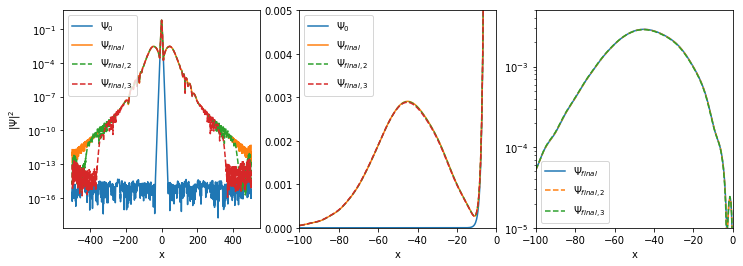

In [15]:
fig, (ax1, ax2, ax3) = subplots(1, 3,figsize=(12,4))

ax1.plot(real(femgrid.xz),abs(Phi0/sqrt(femgrid.wz)),label="$\Psi_{0}$")
ax1.plot(real(femgrid.xz),abs(phifinal/sqrt(femgrid.wz)),"-",label="$\Psi_{final}$")
ax1.plot(real(femgrid.xz),abs(phifinal_2/sqrt(femgrid.wz)),"--",label="$\Psi_{final,2}$")
ax1.plot(real(femgrid.xz),abs(phifinal_3/sqrt(femgrid.wz)),"--",label="$\Psi_{final,3}$")
ax1.legend()
ax1.set_yscale("log")
#xlim(-200,-150)
ax1.set_xlabel("x")
ax1.set_ylabel("$|\Psi|^2$")




ax2.plot(real(femgrid.xz),abs(Phi0/sqrt(femgrid.wz)),label="$\Psi_{0}$")
ax2.plot(real(femgrid.xz),abs(phifinal/sqrt(femgrid.wz)),"-",label="$\Psi_{final}$")
ax2.plot(real(femgrid.xz),abs(phifinal_2/sqrt(femgrid.wz)),"--",label="$\Psi_{final,2}$")
ax2.plot(real(femgrid.xz),abs(phifinal_3/sqrt(femgrid.wz)),"--",label="$\Psi_{final,3}$")
ax2.legend()
ax2.set_xlim(-100,0)
ax2.set_ylim(0,0.005)
ax2.set_xlabel("x")




ax3.plot(real(femgrid.xz),abs(phifinal_subphi0/sqrt(femgrid.wz)),"-",label="$\Psi_{final}$")
ax3.plot(real(femgrid.xz),abs(phifinal2_subphi0/sqrt(femgrid.wz)),"--",label="$\Psi_{final,2}$")
ax3.plot(real(femgrid.xz),abs(phifinal3_subphi0/sqrt(femgrid.wz)),"--",label="$\Psi_{final,3}$")
ax3.legend()
ax3.set_xlim(-100,0)
ax3.set_ylim(1.e-5,0.005)
ax3.set_yscale("log")
ax3.set_xlabel("x")



In [18]:
ec=w0+e0
H=csc_matrix(real(Ekin+diag(V)))
e1,v1=eigs((H),k=40,which='SR',sigma=ec)
e2,v2=eigs((H),k=40,which='LR',sigma=ec)
e=concatenate((e1[::-1],e2))
v=concatenate((v1[:,::-1].transpose(),v2.transpose()))

Text(0, 0.5, 'ionisation prob.')

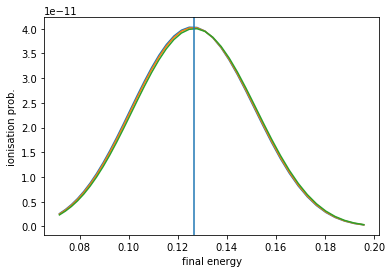

In [19]:
for phifinalx in [phifinal,phifinal_2,phifinal_3]:
    cs=array([ abs(phifinalx.dot(conjugate(v[i,:])))**2 for i in range(len(e))])
    energy,prob=real(e)[cs<1.e-10],cs[cs<1.e-10]
    plot(energy,prob/sqrt(energy))
axvline(x=ec)
xlabel("final energy")
ylabel("ionisation prob.")